In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import librosa
import librosa.display
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import Audio

from model.ddsp.harmonic_oscillator import OscillatorBank

In [2]:
plt.rcParams['figure.figsize'] = [17, 8]

In [3]:
sample_rate = 48000
n_harmonics = 100

In [64]:
try:
    del synth
except NameError:
    pass
synth = OscillatorBank(n_harmonics=n_harmonics, sample_rate=sample_rate, hop_size=512).cuda()

In [79]:
sequence_length = 512
f0 = 55
f0s = f0 * torch.ones((3, sequence_length, 1))
f0s[:, -sequence_length//2:] *= 2 ** (3/12)
adsr = torch.linspace(f0, f0 * (2**(3/12)), steps=sequence_length//32).unsqueeze(-1)
f0s[:, -sequence_length//2-sequence_length//64:-sequence_length//2+sequence_length//64] = adsr

amps = torch.ones((3, sequence_length, 1)) * 0.8
adsr = torch.linspace(0.8, 0.1, steps=sequence_length//4)
amps[:, :sequence_length//4, 0] = adsr
adsr = torch.linspace(0.1, 0.8, steps=sequence_length//4)
amps[:, sequence_length//4:sequence_length//2, 0] = adsr

harmonic_envelop = 1. / torch.linspace(1., 101., steps=n_harmonics) ** 2.
# harm_amps = torch.ones((sequence_length, n_harmonics)) * harmonic_envelop
harm_amps = torch.ones((3, sequence_length, n_harmonics))
for idx in range(n_harmonics):
    harm_amps[:, :, idx] = 1 / ((idx + 1) ** 2)

harm_dists = torch.zeros((3, sequence_length, 1))
# dist_env = torch.linspace(-0.03, -0.03, sequence_length//2)
# harm_dists[-sequence_length//2:, 0] += dist_env

f0s, amps, harm_amps, harm_dists = f0s.cuda(), amps.cuda(), harm_amps.cuda(), harm_dists.cuda()

In [85]:
f0s[0] *= 2

In [86]:
ys = synth(f0s, amps, harm_amps, harm_dists)

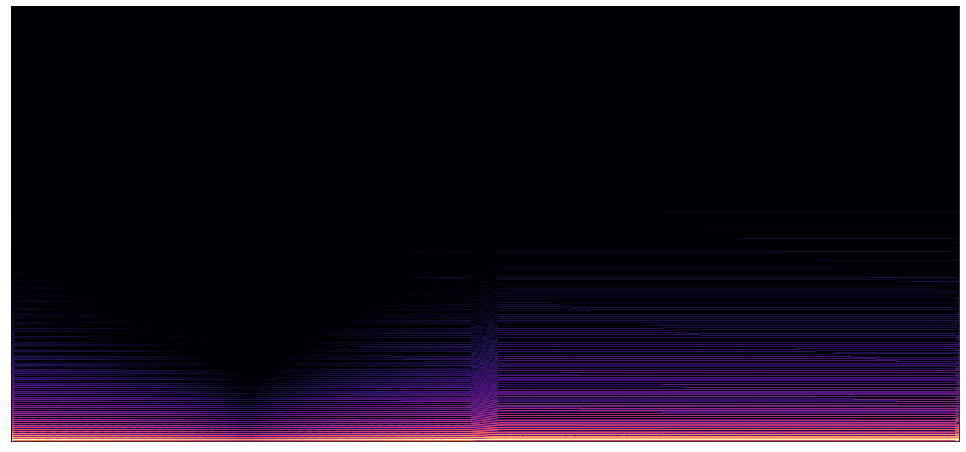

In [88]:
y = ys.cpu().numpy()
stfts = [np.abs(librosa.stft(yy)) for yy in y]
librosa.display.specshow(librosa.amplitude_to_db(stfts[0]))

In [90]:
Audio(data=y[1], rate=sample_rate)